## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**QUESTION:** Load dataset and display some lines of the csv file.

In [6]:
data = pd.read_csv("ai4i2020.csv")
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


We can see that the input data are :
- UDI
- Product ID
- Product type
- Air temperature
- Process temperature
- Rotational speed
- Torque
- Tool wear
- Machine failure

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

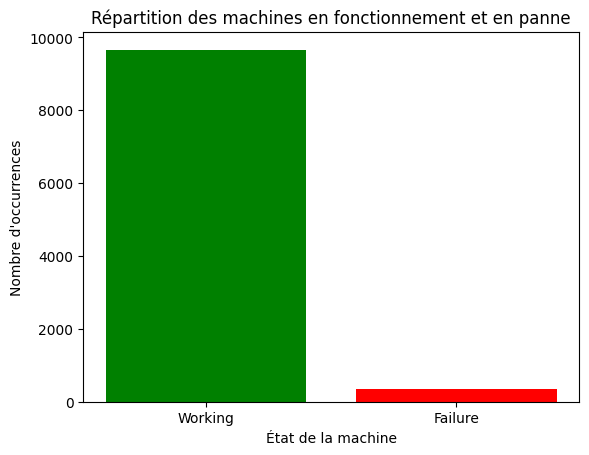

Nombre d'occurrences de chaque état :
 Machine failure
0    9661
1     339
Name: count, dtype: int64


In [9]:
counts_failure = data['Machine failure'].value_counts()

plt.bar(counts_failure.index, counts_failure.values, color=["green", "red"])

plt.xticks([0, 1], ["Working", "Failure"])  # Noms des catégories
plt.xlabel("État de la machine")
plt.ylabel("Nombre d'occurrences")
plt.title("Répartition des machines en fonctionnement et en panne")

plt.show()
print("Nombre d'occurrences de chaque état :\n", counts_failure)

**ANALYSIS QUESTION:** What do you observe?


Lorsque nous affichons les données nous mettons les RNF dans la colonne Working. En effet lorsqu'un RNF a lieu cela n'est pas répertorié comme une 'Machine Failure'. On les retrouve donc dans la colonne Working ce qui est cohérent puisque ces problèmes sont aléatoires et que l'objectif de notre modèle est de prévoir les problèmes sur les machines. Nous ne pouvons pas prévoir les problèmes aléatoires, il est donc cohérent que nous ne comptabilisions pas ces Fail aléatoires comme des Fails puisque nous ne souhaitons pas les prendre en compte dans l'apprentissage.

Au final nous voyons que nous avons peu de données pour les Failure (uniquement 339). Cela va donc compliquer l'apprentissage.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Nous avons peu de données répertoriant des Fails dans notre Dataset. Notre objectif est d'identifier les pannes sur la machine et nous avons seulement 339 réferencements de pannes. Ainsi, même si notre Dataset est de grande taille il n'est pas très complet car 96,51% des données correspondent à un fonctionnement normal.

Notre apprentissage risque donc d'être peu précis à cause d'une faible quantité de données.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

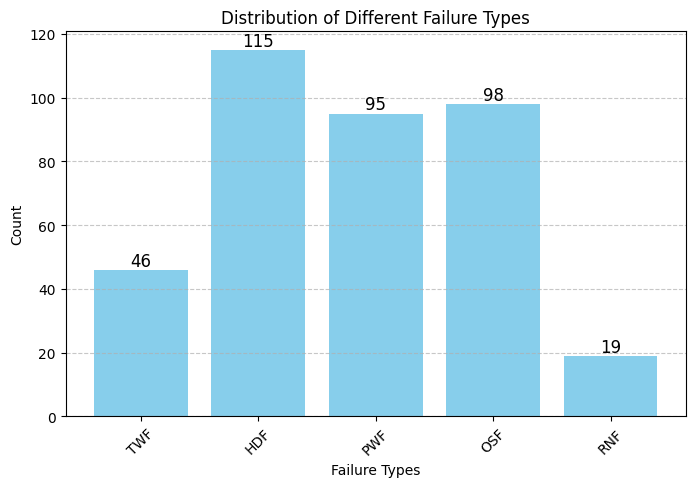

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv("ai4i2020.csv")

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = dataset[failure_types].sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color='skyblue')

# value above each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             int(bar.get_height()), ha='center', va='bottom', fontsize=12)

plt.xlabel("Failure Types")
plt.ylabel("Count")
plt.title("Distribution of Different Failure Types")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

"Write your response here"

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

"Write your response here"

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**QUESTION** Code below the model architecture

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"